In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

In [2]:
# Define transformations for training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = ImageFolder(root='dataset_13', transform=transform)

In [5]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store cross-validation results
cv_train_losses = []
cv_val_losses = []
cv_train_accuracies = []
cv_val_accuracies = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 4

# Path to the pre-trained model weights from previous training (if any)
pretrained_model_path = 'models/transfer_vgg_best.pth'

labels = [sample[1] for sample in dataset.samples]

for fold, (train_index, val_index) in enumerate(kf.split(np.zeros(len(labels)), labels)):
    print(f'Fold {fold + 1}')
    
    train_subset = Subset(dataset, train_index)
    val_subset = Subset(dataset, val_index)
    
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False, num_workers=4)
    
    # Reinitialize the model and load the pre-trained weights
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.classifier[6] = nn.Linear(4096, num_classes)
    
    # Load pre-trained weights from previous training (if available)
    try:
        model.load_state_dict(torch.load(pretrained_model_path))
        print("Loaded pre-trained weights from previous training.")
    except FileNotFoundError:
        print("No pre-trained weights found, using ImageNet pre-trained weights.")

    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    scaler = GradScaler()  # For mixed precision training
    
    # Optionally, freeze the first few layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Training loop
    num_epochs = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    cv_train_losses.append(train_losses)
    cv_val_losses.append(val_losses)
    cv_train_accuracies.append(train_accuracies)
    cv_val_accuracies.append(val_accuracies)

Fold 1
Loaded pre-trained weights from previous training.
Epoch 1/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 2/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 3/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 4/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 5/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 6/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 7/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 8/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 9/10, Train Loss: nan, Train Accuracy: 0.2370
Validation Loss: nan, Validation Accuracy: 0.3021
Epoch 10/10, Train Loss:

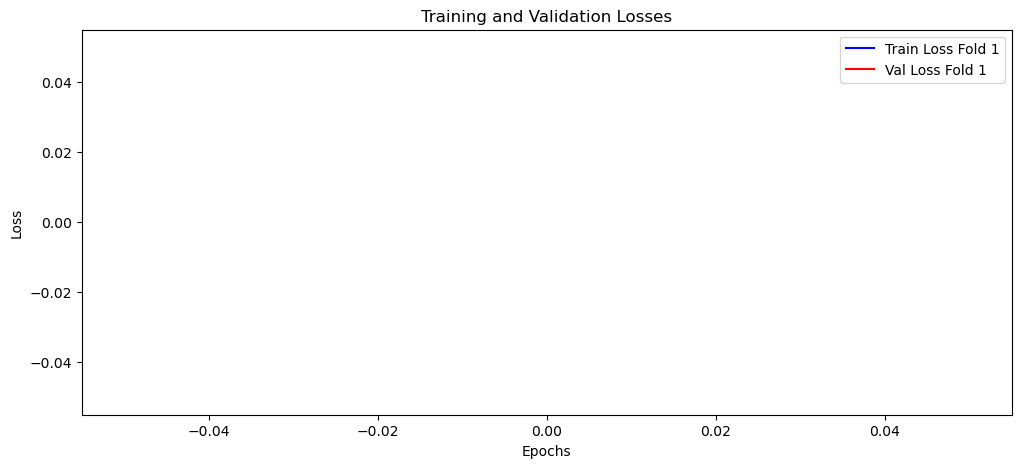

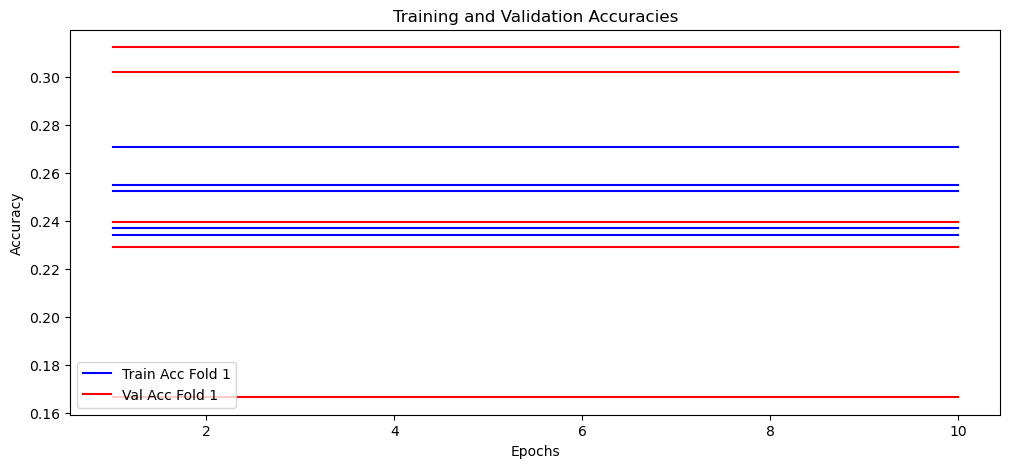

In [6]:
# Plot the results
epochs = range(1, num_epochs + 1)

# Plot the training and validation losses
plt.figure(figsize=(12, 5))
for fold in range(len(cv_train_losses)):
    plt.plot(epochs, cv_train_losses[fold], 'b-', label=f'Train Loss Fold {fold + 1}' if fold == 0 else "")
    plt.plot(epochs, cv_val_losses[fold], 'r-', label=f'Val Loss Fold {fold + 1}' if fold == 0 else "")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(12, 5))
for fold in range(len(cv_train_accuracies)):
    plt.plot(epochs, cv_train_accuracies[fold], 'b-', label=f'Train Acc Fold {fold + 1}' if fold == 0 else "")
    plt.plot(epochs, cv_val_accuracies[fold], 'r-', label=f'Val Acc Fold {fold + 1}' if fold == 0 else "")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()